In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [4]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)

In [5]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def tensor(self):
        return torch.stack([s.tensor() for s in self.sentences])

In [12]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [13]:
class SentenceEncoder(nn.Module):
    
    def __init__(self, embed_dim=300, hidden_dim=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu', batch_first=True)

    def forward(self, x):
        hidden = Variable(torch.zeros(1, len(x), self.hidden_dim))
        rnn_out, hidden = self.rnn(x, hidden)
        return hidden

In [14]:
class Model(nn.Module):
    
    def __init__(self, input_dim=128, hidden_dim=128):
        super().__init__()
        self.i2h = nn.Linear(2*input_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        y = F.relu(self.i2h(x))
        y = F.sigmoid(self.h2o(y))
        return y

In [15]:
train = Corpus('../data/train.json/*.json', 100)

In [24]:
torch.manual_seed(1)

In [25]:
sent_encoder = SentenceEncoder()

In [26]:
model = Model()

In [27]:
criterion = nn.BCELoss()

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def train_pair(model, s1, s2, y):
    
    x = torch.cat([s1, s2])
    
    model.zero_grad()

    y = Variable(torch.FloatTensor([y]))
    y_pred = model(x)

    loss = criterion(y_pred, y)
    loss.backward(retain_graph=True)

    optimizer.step()
    
    return loss.data[0]

In [30]:
train_loss = []
for epoch in range(50):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for ab in train.abstracts():
        
        sent_encoder.zero_grad()
        
        sents = ab.tensor()
        sents = Variable(sents)
        sents = sent_encoder(sents)
        
        for s1, s2 in pairwise(sents[0]):
            epoch_loss += train_pair(model, s1, s2, 1)
            epoch_loss += train_pair(model, s2, s1, 0)

    epoch_loss /= (train.skim*2)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0), HTML(value='')))


3.102164278924465
Epoch 1


HBox(children=(IntProgress(value=0), HTML(value='')))


3.089445431530476
Epoch 2


HBox(children=(IntProgress(value=0), HTML(value='')))


3.07293033644557
Epoch 3


HBox(children=(IntProgress(value=0), HTML(value='')))


3.046984163224697
Epoch 4


HBox(children=(IntProgress(value=0), HTML(value='')))


3.0117221654951574
Epoch 5


HBox(children=(IntProgress(value=0), HTML(value='')))


2.9644825552403926
Epoch 6


HBox(children=(IntProgress(value=0), HTML(value='')))


2.9067112546414138
Epoch 7


HBox(children=(IntProgress(value=0), HTML(value='')))


2.838482280597091
Epoch 8


HBox(children=(IntProgress(value=0), HTML(value='')))


2.7634474362432955
Epoch 9


HBox(children=(IntProgress(value=0), HTML(value='')))


2.680532176028937
Epoch 10


HBox(children=(IntProgress(value=0), HTML(value='')))


2.6011340859532357
Epoch 11


HBox(children=(IntProgress(value=0), HTML(value='')))


2.517083804868162
Epoch 12


HBox(children=(IntProgress(value=0), HTML(value='')))


2.4290366437798365
Epoch 13


HBox(children=(IntProgress(value=0), HTML(value='')))


2.3439603866217658
Epoch 14


HBox(children=(IntProgress(value=0), HTML(value='')))


2.2547309543634766
Epoch 15


HBox(children=(IntProgress(value=0), HTML(value='')))


2.1709709438530265
Epoch 16


HBox(children=(IntProgress(value=0), HTML(value='')))


2.0856569594785106
Epoch 17


HBox(children=(IntProgress(value=0), HTML(value='')))


2.0019224886549636
Epoch 18


HBox(children=(IntProgress(value=0), HTML(value='')))


1.9227232073911
Epoch 19


HBox(children=(IntProgress(value=0), HTML(value='')))


1.8381054899003357
Epoch 20


HBox(children=(IntProgress(value=0), HTML(value='')))


1.7640062170877355
Epoch 21


HBox(children=(IntProgress(value=0), HTML(value='')))


1.688807794909808
Epoch 22


HBox(children=(IntProgress(value=0), HTML(value='')))


1.6171719817857957
Epoch 23


HBox(children=(IntProgress(value=0), HTML(value='')))


1.543993258298724
Epoch 24


HBox(children=(IntProgress(value=0), HTML(value='')))


1.4770544698763843
Epoch 25


HBox(children=(IntProgress(value=0), HTML(value='')))


1.4099892031312629
Epoch 26


HBox(children=(IntProgress(value=0), HTML(value='')))


1.3549451411463087
Epoch 27


HBox(children=(IntProgress(value=0), HTML(value='')))


1.2950458419853386
Epoch 28


HBox(children=(IntProgress(value=0), HTML(value='')))


1.2619065641482576
Epoch 29


HBox(children=(IntProgress(value=0), HTML(value='')))


1.2190181811846832
Epoch 30


HBox(children=(IntProgress(value=0), HTML(value='')))


1.1670669338367134
Epoch 31


HBox(children=(IntProgress(value=0), HTML(value='')))


1.110885180190146
Epoch 32


HBox(children=(IntProgress(value=0), HTML(value='')))


1.0642287366436427
Epoch 33


HBox(children=(IntProgress(value=0), HTML(value='')))


1.0107755819848034
Epoch 34


HBox(children=(IntProgress(value=0), HTML(value='')))


0.9988935114575793
Epoch 35


HBox(children=(IntProgress(value=0), HTML(value='')))


0.9351851540093719
Epoch 36


HBox(children=(IntProgress(value=0), HTML(value='')))


0.9099340548307373
Epoch 37


HBox(children=(IntProgress(value=0), HTML(value='')))


0.8516068476100956
Epoch 38


HBox(children=(IntProgress(value=0), HTML(value='')))


0.8413531174966454
Epoch 39


HBox(children=(IntProgress(value=0), HTML(value='')))


0.7818936040111442
Epoch 40


HBox(children=(IntProgress(value=0), HTML(value='')))


0.7824681654493406
Epoch 41


HBox(children=(IntProgress(value=0), HTML(value='')))


0.722359707510971
Epoch 42


HBox(children=(IntProgress(value=0), HTML(value='')))


0.7283795217684589
Epoch 43


HBox(children=(IntProgress(value=0), HTML(value='')))


0.6599550464009714
Epoch 44


HBox(children=(IntProgress(value=0), HTML(value='')))


0.6594054161373921
Epoch 45


HBox(children=(IntProgress(value=0), HTML(value='')))


0.5937150761579553
Epoch 46


HBox(children=(IntProgress(value=0), HTML(value='')))


0.593160018775827
Epoch 47


HBox(children=(IntProgress(value=0), HTML(value='')))


0.5356911188618416
Epoch 48


HBox(children=(IntProgress(value=0), HTML(value='')))


0.5640002311584118
Epoch 49


HBox(children=(IntProgress(value=0), HTML(value='')))


0.5021254098326626


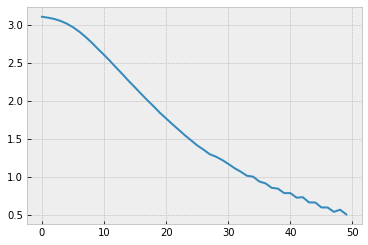

In [31]:
plt.plot(train_loss)